## Murine bone-marrow derived macrophages

https://data.broadinstitute.org/bbbc/BBBC020/

## Make a torch dataset

In [1]:
from segmentation.datasets import BroadDataset

### Show some images

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
base = '/Users/nicholassofroniew/Documents/BBBC/BBBC020_v1'
train_dataset = BroadDataset(base, 'train')

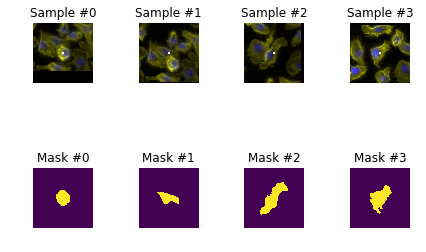

In [4]:
fig = plt.figure()

for i in range(len(train_dataset)):
    img, mask = train_dataset[i]

#    print(i, sample['image'].shape)

    ax = plt.subplot(2, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(img)
    ax = plt.subplot(2, 4, i + 5)
    ax.set_title('Mask #{}'.format(i))
    ax.axis('off')
    plt.imshow(mask)
    if i == 3:
        plt.show()
        break

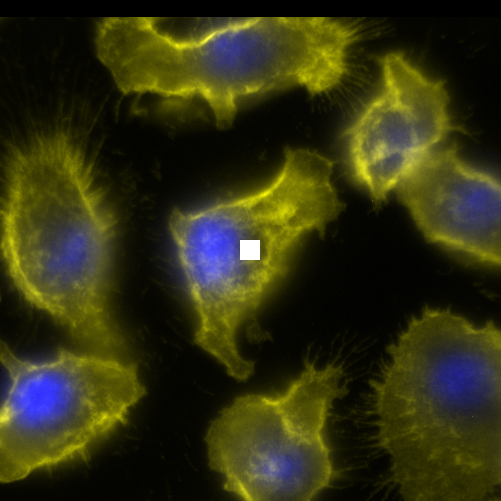

In [5]:
img

## Define transforms

In [6]:
from torchvision import transforms
import segmentation.transforms as extended_transforms

joint_transform = extended_transforms.Compose([
    extended_transforms.RandomHorizontallyFlip(),
    extended_transforms.RandomVerticallyFlip(),
    extended_transforms.RandomCrop(450)])

input_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
target_transform = extended_transforms.MaskToTensor()

In [7]:
train_dataset = BroadDataset(base, 'train', joint_transform=joint_transform, input_transform=input_transform, target_transform=target_transform)

In [14]:
from torch.utils.data import DataLoader
trainloader = DataLoader(train_dataset, batch_size=1,
                                          shuffle=True, num_workers=2)

## Load network

In [8]:
from segmentation.model import UNet

In [9]:
net = UNet(1)

In [10]:
net.train()

UNet (
  (enc1): _EncoderBlock (
    (encode): Sequential (
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (2): ReLU (inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (5): ReLU (inplace)
      (6): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    )
  )
  (enc2): _EncoderBlock (
    (encode): Sequential (
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
      (2): ReLU (inplace)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
      (5): ReLU (inplace)
      (6): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    )
  )
  (enc3): _EncoderBlock (
    (encode): Sequential (
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
     

### Define loss function and optimizer

In [11]:
from segmentation.utilities import mIoULoss

In [12]:
criterion = mIoULoss(size_average=False)
#criterion = nn.NLLLoss2d()

In [13]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Pass data throuhg network

In [15]:
import torch.nn.functional as F
from torch.autograd import Variable
img, mask = train_dataset[0]
tmp = Variable(mask).unsqueeze(0)
foo = net(Variable(img).unsqueeze(0))
bar = F.log_softmax(foo)

In [16]:
print(tmp)
print(foo)
print(bar)

Variable containing:
( 0 ,.,.) = 
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
[torch.LongTensor of size 1x450x450]

Variable containing:
( 0 , 0 ,.,.) = 
 -5.6065e-01 -3.7454e-01 -2.9866e-01  ...  -5.5658e-01 -4.0687e-01 -1.2698e-01
 -7.2447e-01 -4.7268e-01 -3.6087e-01  ...  -6.8173e-01 -5.8061e-01 -3.4798e-01
 -8.0068e-01 -5.0784e-01 -3.7191e-01  ...  -7.3099e-01 -6.6312e-01 -4.6552e-01
                 ...                   ⋱                   ...                
 -4.0405e-01 -3.6223e-01 -3.2511e-01  ...   3.5254e-01  3.2545e-01  2.2545e-01
 -3.4518e-01 -2.4090e-01 -1.9267e-01  ...   2.6644e-01  2.3424e-01  1.5034e-01
 -3.0465e-01 -2.4319e-02  9.0282e-02  ...   1.4705e-01  9.0774e-02 -8.5746e-03
[torch.FloatTensor of size 1x1x450x450]

Variable containing:
( 0 , 0 ,.,.) = 
   0   0   0  ...    0   0   0
   0   0  

In [17]:
loss = criterion(foo, tmp)
print(loss)

Variable containing:
-18.9729
[torch.FloatTensor of size 1]



In [18]:
loss.backward()

### Train network

In [20]:
from segmentation.main import train

In [21]:
for epoch in range(2):  # loop over the dataset multiple times
    train(trainloader, net, criterion, optimizer, epoch)
print('Finished Training')

Process Process-1:
Process Process-2:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/nicholassofroniew/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/nicholassofroniew/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/nicholassofroniew/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/nicholassofroniew/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/nicholassofroniew/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/Users/nicholassofroniew/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/Users/nicholassofroniew/ana

KeyboardInterrupt: 

### Load and save model

In [33]:
import torch
from os.path import join
snapshot_name = 'UNet'

In [170]:
torch.save(net.state_dict(), join(base, 'models', snapshot_name + '.pth'))
torch.save(optimizer.state_dict(), join(base, 'models', 'opt_' + snapshot_name + '.pth'))

In [34]:
net.load_state_dict(torch.load(join(base, 'models', snapshot_name + '.pth')))
optimizer.load_state_dict(torch.load(join(base, 'models', 'opt_' + snapshot_name + '.pth')))

### Look at perforance on validation set

In [35]:
val_dataset = BroadDataset(base, 'val', joint_transform=joint_transform, input_transform=input_transform, target_transform=target_transform)

In [52]:
from torch.autograd import Variable
img, mask = val_dataset[20]
output = net(Variable(img).unsqueeze(0))

In [53]:
#prediction = output.data.max(1)[1].squeeze_(1).squeeze_(0) #.cpu().numpy() #max(1)[1] is equiv to argmax
#prediction = F.log_softmax(output)
prediction = output

In [54]:
prediction.data.squeeze(1).squeeze(0).numpy().shape

(450, 450)

[ 87.22505951]


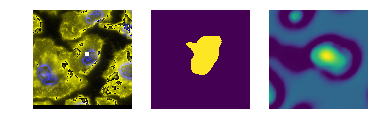

In [55]:
ax = plt.subplot(1,3,1);
plt.imshow(img.numpy().transpose(1,2,0))
ax.axis('off');
ax = plt.subplot(1,3,2);
plt.imshow(mask.numpy())
ax.axis('off');
ax = plt.subplot(1,3,3);
plt.imshow(prediction.squeeze(0).squeeze(0).data.numpy())
ax.axis('off');
loss = criterion(output, Variable(mask).unsqueeze(0))
print(loss.data.numpy())

In [27]:
valloader = DataLoader(val_dataset, batch_size=1,
                                          shuffle=True, num_workers=2)

In [177]:
correct = 0
total = 0
for data in valloader:
    images, labels = data
    outputs = net(Variable(images))
    loss = criterion(output, Variable(labels)).data.numpy()[0]

    print(loss)
    total += labels.size(0)
    correct += loss

print('Mean Intersection Over Union: %.2f %%' % (
    correct / total))

99.9929
99.995
99.9983
99.993
99.9897
99.998
99.9983
99.9957
99.991
99.9923
99.9928
99.9966
99.9933
99.994
99.9945
99.9921
99.9925
99.993
99.9977
99.9925
99.997
99.9964
99.9973
99.997
99.9941
99.9912
99.9922
99.9983
99.991
99.9948
99.9952
99.9964
99.9952
99.9958
99.9889
99.9939
99.9909
99.9913
99.9934
99.9973
99.995
99.9938
99.9887
99.9976
99.9981
99.9919
99.998
99.9919
99.9941
99.993
99.9921
99.9926
99.997
99.9979
99.9921
99.9948
99.993
99.9972
99.995
99.9986
99.9977
99.9972
99.9927
99.9979
99.9944
99.9945
99.9937
99.9972
99.9896
99.9911
99.9934
99.9966
99.9954
99.995
99.9975
99.9967
99.99
99.9958
99.997
99.9929
99.9944
99.9917
99.9886
99.9974
99.9934
99.9963
99.9895
99.9883
99.998
99.9959
99.9897
99.9895
99.9915
99.9959
Mean Intersection Over Union: 9999.42 %


In [143]:
def mIoU(output, target):
    intersection = output*target
    union = (output + target)>0
    return intersection.sum()/union.sum()

In [ ]:
correct = 0
total = 0
for data in valloader:
    images, labels = data
    outputs = net(Variable(images))
    predicted = output.data.max(1)[1]
    m = mIoU(predicted, labels)
    print(m*100)
    total += labels.size(0)
    correct += m

print('Mean Intersection Over Union: %.2f %%' % (
    100 * correct / total))